In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import glob
import sys
import random
import tqdm as tqdm

import matplotlib.pyplot as plt

from skimage.io import imread, imshow
from skimage.color import rgb2gray
from skimage.transform import resize

from keras.models import Sequential, Model, load_model
from keras.layers import Input, BatchNormalization, merge, GlobalMaxPooling2D, Lambda
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras import backend as K
from keras.applications.vgg19 import VGG19

import tensorflow as tf

from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier

from scipy.stats import norm

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#Going through the images one by one, we found some of the images that are not good for training, due to bad quality, photo taken too far away, bad image angle or simply too noisy. these images are listed below.
bad_image=['0ae69f1e.jpg', '0b1e39ff.jpg', '0d614410.jpg', '0fb4c4dd.jpg', '01c11eaf.jpg', '1ae163da.jpg', '2a2ecd4b.jpg', '2bc459eb.jpg', '2c824757.jpg', '2f1b1a58.jpg', '3e793658.jpg', '3f919786.jpg', '4d818204.jpg',
           '05d402e7.jpg', 'obde3564.jpg', '5efe6139.jpg', '06ffe77b.jpg', '6b9f5632.jpg', '6bc32ac5.jpg', '7a399627.jpg', '7aadcef5.jpg', '7cc11b57.jpg', '7d008e04.jpg', '7eacaef2.jpg', '7f048f21.jpg', '7f7702dc.jpg', 
           '8aafd575.jpg', '8b615df8.jpg', '8bd96828.jpg', '8eb500b3.jpg', '9e6ff81f.jpg', '19b2000c.jpg', '29ab7864.jpg', '35e0706e.jpg', '53ccd15c.jpg', '54aeef4a.jpg', '55cb38a4.jpg', '56fafc52.jpg', '69d946a0.jpg', 
           '68ffd7bf.jpg', '73cfb77f.jpg', '342ea7cf.jpg', '383eb5a3.jpg', '734d181a.jpg', '761b8f76.jpg', '806cf583.jpg', '851a3114.jpg', '932d8f1e.jpg', '993f0479.jpg', '1323a889.jpg', '3401bafe.jpg', '14944e45.jpg', 
           '20594d9d.jpg', '28405ee2.jpg', '34333c52.jpg', '43189ff2.jpg', '91885aec.jpg', '300806a1.jpg', '666282d2.jpg', '1990152d.jpg', '42025982.jpg', '95226283.jpg', 'a3e9070d.jpg', 'a3844c28.jpg', 'a2095252.jpg', 
           'ade8176b.jpg', 'ae2f76dc.jpg', 'b1cfda8a.jpg', 'b006cec6.jpg', 'b6e4f09a.jpg', 'b985ae1e.jpg', 'b9315c19.jpg', 'bc5bf694.jpg', 'c8d44ff3.jpg', 'c97c3ae6.jpg', 'c482d51b.jpg', 'c912ac66.jpg', 'c6854c76.jpg', 
           'cc8eb5e2.jpg', 'ced4a25c.jpg', 'cf756424.jpg', 'd14f0126.jpg', 'd79047b6.jpg', 'd781262d.jpg', 'd1502267.jpg', 'dc0e29fe.jpg', 'dc79e75f.jpg', 'de5e2ea7.jpg', 'de8d631f.jpg', 'e0b00a14.jpg', 'e6ce415f.jpg', 
           'e9bd2e9c.jpg', 'e30d9525.jpg', 'e53d2b96.jpg', 'eafadfb3.jpg', 'ee897d4a.jpg', 'f00f98fb.jpg', 'f1b24b92.jpg', 'f4063698.jpg', 'fb2271f1.jpg']

print (f'Total of {len(bad_image)} images are not suitable for training')

Total of 100 images are not suitable for training


Total train files = 9752
Total unique ID= 4236


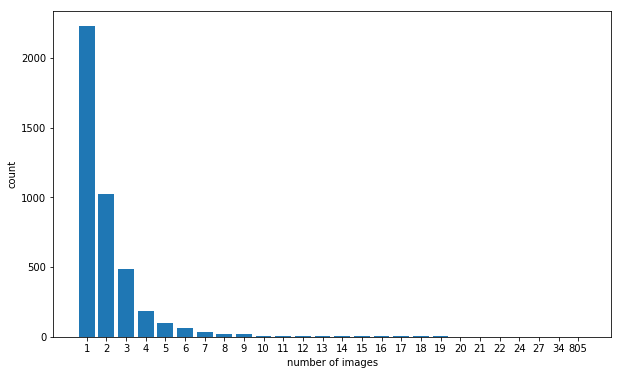

new_whale    805
w_1287fbc     34
w_98baff9     27
w_7554f44     24
w_693c9ee     22
Name: Id, dtype: int64

8.254716981132075% of images are new whale


In [3]:
#Define train and test path
TRAIN_PATH="../input/whale-categorization-playground/train/"
TEST_PATH="../input/whale-categorization-playground/test/"

#read train file summary, minus bad files
df=pd.read_csv('../input/whale-categorization-playground/train.csv')
df=df[~df['Image'].isin(bad_image)]

#set 20% of image for validation purpose
np.random.seed(100)
df['train']=np.random.randint(0,10, len(df))>1

print (f'Total train files = {len(df)}')

#group the train files by ID
ID_freq=df['Id'].value_counts()
print (f'Total unique ID= {len(ID_freq)}')

ID_count_by_freq=ID_freq.value_counts()
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(ID_count_by_freq)+1), list(ID_count_by_freq))
plt.xticks(np.arange(1, len(ID_count_by_freq)+1), list(ID_freq.unique()[::-1]))
plt.xlabel('number of images')
plt.ylabel('count')
plt.show()

print (ID_freq.head())
#find out how many percent of train file consist of new whale
percent_new_whale= ID_freq.loc['new_whale']/len(df)
print (f'\n{percent_new_whale*100}% of images are new whale')

Majority of ID have only one, two or three images.
about 10% of images (after removing bad images) are new whale.

In [4]:
"Uncomment to train on train files only"
#df_train=df[df['train']==True]
"Uncomment to train on all files"
df_train=df.copy()

ID_freq=df_train['Id'].value_counts()


I also created a simple neural network that localize the whale fluke from the image. This model return upper left and bottom right corner of the bounding box for the fluke. We use the outcome to crop the image before feeding them for training.

Credit to @lisa needs braces for providing training set. (https://www.kaggle.com/c/whale-categorization-playground/discussion/57108)



In [5]:
train_crop_table=pd.read_csv('../input/crop-coordinate/train_crop_coordinate.csv', index_col=0)
test_crop_table=pd.read_csv('../input/crop-coordinate/test_crop_coordinate.csv', index_col=0)

"""
In this table:
"image"                     -- image name
"ori height"                -- original height of the image
"ori width                  -- original width of the image
"ystart, xstart"            -- the upper left corner of bounding box of the image in 224x224 size
"yend, xend"                -- the bottom right corner of bounding box of the image in 224x224 size
"new ystart, new xstart"    -- the upper left corner of bounding box of the image in original size
"new yend, new xend"        -- the bottom right corner of bounding box of the image in original size
"""

train_crop_table.head()

,image,ori height,ori width,ystart,xstart,yend,xend,new ystart,new xstart,new yend,new xend
0,8ab4077d.jpg,158,300,30,10,189,211,21,13,133,283
1,f32f6809.jpg,591,1050,68,36,149,188,179,169,393,881
2,76caefe3.jpg,503,1050,1,4,198,208,2,19,445,975
3,e39b55ef.jpg,450,1050,17,1,149,218,34,5,299,1022
4,29910dbd.jpg,430,1050,9,2,185,211,17,9,355,989


In [6]:
IMG_SHAPE=(224, 224, 3)
OUTPUT_DIMENSION=800
#define base model for croping and triplet loss
def get_base_model():
    """ load vgg19 model with no top, add final output as dense layer with dimension OUTPUT_DIMENSION
    """
    
    base_model=VGG19(include_top=False, weights=None)
    #base_model.load_weights('../input/vgg19/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5', by_name=True)
    base_model.load_weights('../input/vgg19/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5', by_name=True)
    
    x=base_model.output
    x=GlobalMaxPooling2D()(x)
    x=Dropout(0.3)(x)
    dense_1=Dense(OUTPUT_DIMENSION)(x)
    normalized=Lambda(lambda x: K.l2_normalize(x, axis=1))(dense_1)
    base_model=Model(base_model.input, normalized)
    return base_model

def get_triplet_model(lr=0.001):
    input1=Input(IMG_SHAPE)
    input2=Input(IMG_SHAPE)
    input3=Input(IMG_SHAPE)
    
    output1=base_model(input1)
    output2=base_model(input2)
    output3=base_model(input3)
    
    loss=merge([output1, output2, output3], mode=triplet_loss, output_shape=(1,))
    
    model=Model(inputs=[input1, input2, input3], outputs=loss)
    model.compile(loss=identity_loss, optimizer=Adam(lr))
    return model

def triplet_loss(X, alpha=0.2):
    pos, neg, anchor=X
    pos_dist=tf.reduce_sum(tf.square(tf.subtract(anchor, pos)), axis=-1)
    neg_dist=tf.reduce_sum(tf.square(tf.subtract(anchor, neg)), axis=-1)
    basic_loss=tf.add(tf.subtract(pos_dist, neg_dist), alpha)
    
    loss=tf.reduce_mean(tf.maximum(basic_loss, 0))
    return loss

def identity_loss(y_true, y_pred):
    return K.mean(y_pred-0*y_true)

def check_id(image):
    ID=df['Id'][df['Image']==image].iloc[0]
    return ID

def crop_image(images, train=True):
    """take in images, crop according to train/test crop table, resize to IMG_SHAPE
    
    Arguments:
    images-- list consist of image name to be cropped
    train-- bool, True if the images are from train, False if test
    
    return:
    output_array-- array with axis-0 as number of images, axis-1 to 3 as cropped array of the input images
    """
    output_array=np.zeros((len(images), IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2]))
    for n, image in enumerate (images):
        if train:
            path=TRAIN_PATH+image
            table=train_crop_table.copy()
        else:
            path=TEST_PATH+image
            table=test_crop_table.copy()
            
        ystart=table['new ystart'][table['image']==image].values
        xstart=table['new xstart'][table['image']==image].values
        yend=table['new yend'][table['image']==image].values
        xend=table['new xend'][table['image']==image].values
        
        img_array=imread(path)
        height, width=img_array.shape[0], img_array.shape[1]
        
        #provide 10 pixel of margin, so that we are sure that entire flute will be cropped.
        ystart=int(max(ystart-10, 0))
        xstart=int(max(xstart-10, 0))
        yend=int(min(yend+10, height))
        xend=int(min(xend+10, width))
        
        #if image is greyscale, convert it to rgb with all channel = greyscale channel
        if img_array.ndim==3:
            img_array=img_array[ystart:yend, xstart:xend, :]
            img_array=resize(img_array, IMG_SHAPE)
        else:
            img_array=img_array[ystart:yend, xstart:xend]
            img_array=resize(img_array, (IMG_SHAPE[0], IMG_SHAPE[1]))
            img_array=np.expand_dims(img_array, axis=-1)
            img_array[:,:,:]=img_array
        output_array[n]=img_array
    return output_array

def generate_ID_map(unique_ID):
    """ 
    generate a dictionary to map ID in unique_ID to its corresponding images, distances and indices among the images of the same ID
    """
    global ID_map
    
    for ID in unique_ID:
        img_lst=list(df_train['Image'][df_train['Id']==ID])
        img_array=crop_image(img_lst)
        encoding=base_model.predict(img_array)
        nbrs=NearestNeighbors(n_neighbors=len(img_lst), algorithm= 'ball_tree').fit(encoding)
        dist, indices=nbrs.kneighbors(encoding)
        centroid=find_centroid(encoding)
        
        ID_map[ID]={'images':img_lst,
                    'distances': dist, 
                    'indices': indices,
                    'centroid': centroid}
    
    return ID_map

def find_centroid(encoding):
    return np.mean(encoding, axis=0)

def generate_global(img_array):
    global global_dist, global_idx
    img_encoding=base_model.predict(img_array)
    nbrs=NearestNeighbors(n_neighbors=anchor_encoding.shape[0], algorithm= 'ball_tree').fit(anchor_encoding)
    global_dist, global_idx=nbrs.kneighbors(anchor_encoding)

In [7]:
base_model=get_base_model()

input1=Input(IMG_SHAPE)
input2=Input(IMG_SHAPE)
input3=Input(IMG_SHAPE)

output1=base_model(input1)
output2=base_model(input2)
output3=base_model(input3)

loss=merge([output1, output2, output3], mode=triplet_loss, output_shape=(1,))

triplet_model=Model(inputs=[input1, input2, input3], outputs=loss)
triplet_model.compile(loss=identity_loss, optimizer=Adam(10**-5))


In [ ]:
#Select all ID which has at least 2 images, at most 100 (to eliminate "new_whale") for training
ID_SL=list(ID_freq[(ID_freq>=2) & (ID_freq<100)].index)
print ('Generating ID_map...')
ID_map={}
generate_ID_map(ID_SL)
print ("ID_map generated")
print (f'\ntotal number of IDs to train= {len(ID_SL)}')

Generating ID_map...


In [ ]:
"Skip this segment if not loading pretrained weight"
base_model.load_weights('../input/128-min2-max4-crop-e2/min2_max4_crop_e2_128.h5', by_name=True)

In [ ]:
"Skip this segment if not training."

class data_generator:
    def __init__(self, ID_map, ID_lst, batch_size, num_img):
        
        self.ID_lst=ID_lst
        self.batch_size=batch_size
        self.num_img=num_img
        
    
    def find_neighbors(self):
        self.centroid_array=np.zeros((len(ID_map.keys()), OUTPUT_DIMENSION))
        
        for n, ID in enumerate(ID_map.keys()):
            self.centroid_array[n]=ID_map[ID]['centroid']
                    
        centroid_neighbors=NearestNeighbors(n_neighbors=len(self.ID_lst), algorithm='ball_tree').fit(self.centroid_array)
        _, self.nearest_neighbors=centroid_neighbors.kneighbors(self.centroid_array)
        
        return self.centroid_array
      
    def generate_positive(self, img_shortlist):
        self.pos_sample_lst=[]
        for n, image in enumerate(img_shortlist):
            ID=check_id(image)
            img_lst=ID_map[ID]['images']
            idx=img_lst.index(image)
            furthest_pos_idx=ID_map[ID]['indices'][idx, len(img_lst)-1]
            furthest_pos_img=ID_map[ID]['images'][furthest_pos_idx]
            self.pos_sample_lst.append(furthest_pos_img)
        return self.pos_sample_lst
    
    def generate_negative(self, img_shortlist, diff=1):
        self.neg_sample_lst=[]
        for n, image in enumerate(img_shortlist):
            ID=check_id(image)
            idx=self.ID_lst.index(ID)
            #print (self.nearest_neighbors.shape)
            nearest_centroid=self.ID_lst[self.nearest_neighbors[idx, diff]]#diff= 1 to number of ID group, one being the hardest
            nearest_nbrs=random.choice(ID_map[nearest_centroid]['images'])
            self.neg_sample_lst.append(nearest_nbrs)
            #print (self.nearest_neighbors)
        return self.neg_sample_lst
    
    def generate_training_ID_SL(self):
        random.shuffle(self.ID_lst)
        self.img_shortlist=[]
        for ID in ID_SL:
            images=ID_map[ID]['images']
            self.img_shortlist.extend(images)                

    def generate_training_triplet(self):
        while True:
            self.generate_training_ID_SL()
            m=len(self.img_shortlist)
            batches=int(m/self.batch_size)
            indexes=np.arange(batches)
            ID_map=generate_ID_map(ID_SL)
            self.find_neighbors()
            
            for i in indexes:
                if i==indexes[-1]:
                    anchor_lst=self.img_shortlist[i*self.batch_size:]
                       
                else:
                    anchor_lst=self.img_shortlist[i*self.batch_size:(i+1)*self.batch_size]
                
                
                
                pos_lst=self.generate_positive(anchor_lst)
                neg_lst=self.generate_negative(anchor_lst)
                
                anchor_img=crop_image(anchor_lst)
                pos_img=crop_image(pos_lst)
                neg_img=crop_image(neg_lst)
                
                yield([pos_img, neg_img, anchor_img], np.zeros(anchor_img.shape[0]))
                
training_images=[]
ID_SL=list(ID_SL)
print (f'Total number of IDs to be trained is {len(ID_SL)}')
num_img=1500
batch_size=16
steps_per_epoch=int(num_img/batch_size)
training_data=data_generator(ID_map, ID_SL, batch_size, num_img)
triplet_model.fit_generator(training_data.generate_training_triplet(), steps_per_epoch=steps_per_epoch, epochs=10, workers=2)
base_model.save_weights('4th_run 10 epochs')


Training for 10 epochs using all training data takes about 1.5 hours.

Some modification to reduce training that have yet to be tested out:
    1. Use smaller but deeper model as base model. Something like resnet
    2.Further reduce output dimension. High output dimension leads to slow KNN analysis.

To identify the whale based on the encoding, the following steps are taken:
1. Regenerate ID_map, to include all IDs that were not used in training, but not the 'new_whale' ID.
2. Calculate the distance_to_centroid of each image to its' ID centroid. find the mean and std of the distance_to_centroid among the images with same ID.
3. Calculate the average of mean and std of distance_to_centroid for ID that has > 3 images. This average will then be used as the mean and std for ID with <=3 images.
4. generate encoding of test images.
5. create nearest neighbors model with all train encoding. Then find the 30 nearest neighbor of the test encoding.
6. from the 30 nearest neighbors, find out their ID and append to ID list.
7. on each ID, find out their centroid, and the distance of test encoding to the centroid. Generate z-score and probability based on the distance of test encoding to centroid, mean and std distance calculated in step 2.
8. Add 'new_whale' into the ID list, assigning the probability as 0.1 (percent of new_whale in training images)
9. Choose the top 5 ID based on probability
10. generate submission file.


In [ ]:
#step 1 to 3
train_unique_ID=ID_freq.index[1:] #list all ID in training set except 'new_whale'
ID_map={}
train_img_lst=df_train['Image'][df_train['Id']!='new_whale'].tolist()
for ID in train_unique_ID:
    img_lst=list(df_train['Image'][df_train['Id']==ID])
    img_array=crop_image(img_lst)
    train_encoding=base_model.predict(img_array)
    nbrs=NearestNeighbors(n_neighbors=len(img_lst), algorithm= 'ball_tree').fit(train_encoding)
    dist, indices=nbrs.kneighbors(train_encoding)
    centroid=find_centroid(train_encoding)

    if len(img_lst)<=3:
        #assign mean and std with average of mean and std from ID>=5
        mean_dist=0.45 
        std_dist=0.085
    else:
        individual_distance=np.sqrt(np.power(train_encoding-centroid, 2).sum(axis=1))
        mean_dist=np.mean(individual_distance)
        std_dist=np.std(individual_distance)

    ID_map[ID]={'images':img_lst,
                'distances': dist, 
                'indices': indices,
                'centroid': centroid,
                'mean dist': mean_dist,
                'std dist': std_dist}


In view of limited RAM, we will load and store train and test encoding batch by batch.

In [ ]:
#step 4
def encoding_image_list(lst, coordinate_table, train=True):
    encoding=[]
    for fname, array in predict_data_generator(lst, coordinate_table, batch_size=16, train=train):
        encoding.extend(base_model.predict(array))
    return encoding

def predict_data_generator(lst, coordinate_table, batch_size=16, train=True):
        m=len(lst)
        batches=int(m/batch_size)
        indexes=list(range(batches))
        for i in indexes:
            if i==indexes[-1]:
                fname=lst[i*batch_size:]
            else:
                fname=lst[i*batch_size:(i+1)*batch_size] 
            img_array=crop_image(fname, train=train)
            if i%50==0:
                print (i, 'of', indexes[-1], 'loaded')
            yield fname, img_array
        raise StopIteration()

def save_train_encoding():
    print ('loading train encoding list...')
    train_encoding_lst=encoding_image_list(train_img_lst, train_crop_table)
    np.save('train_encoding_lst.npy', train_encoding_lst) 
    print ('loading train encoding list completed')
    return train_encoding_lst
train_encoding_lst=save_train_encoding()

#load all test file name into list
test_file_path=glob.glob('../input/whale-categorization-playground/test/*.jpg')
test_file_path=test_file_path
test_img_lst=[]
for file in test_file_path:
    test_img_lst.append(file.split('/')[-1])
    
def save_test_encoding():
    print ('loading test encoding list...')
    test_encoding_lst=encoding_image_list(test_img_lst, test_crop_table, train=False)
    np.save('test_encoding_lst.npy', test_encoding_lst)
    print ('loading test encoding list completed')
    return test_encoding_lst
test_encoding_lst=save_test_encoding()

In [ ]:
#step 5
n_neighbors=30
nbrs=NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree').fit(train_encoding_lst)

print ('fitting neighbor model...')
dist, idx=nbrs.kneighbors(test_encoding_lst)
print ('fitting neighbor model completed')

In [ ]:
#step 6-9
def choose_top5(test_encoding_lst, NW_cutoff=0.1):
    top5=[]
    m=len(test_encoding_lst)
    for i in range(m):
        if i%500==0:
            print ('analyzing ', i , 'of ', m)
        ID_lst=[]
        cfm_lst=[]

        for j in idx[i]:
            ID=check_id(train_img_lst[j])
            if ID not in ID_lst:
                ID_lst.append(ID)
                centroid=ID_map[ID]['centroid']
                mean_dist=ID_map[ID]['mean dist']
                std_dist=ID_map[ID]['std dist']

                encoding_dist_to_centroid=np.linalg.norm(test_encoding_lst[i]-centroid)
                cfm=1-norm.cdf(encoding_dist_to_centroid, mean_dist, std_dist)
                cfm_lst.append(cfm)
        
        if 'new_whale' not in ID_lst:
            ID_lst.append('new_whale')
            cfm_lst.append(NW_cutoff) ## NW_cutoff as fraction of train files are new whale.
        
        top_5_cfm=np.flip(np.argsort(cfm_lst.copy()), axis=0)
        ID_lst=np.array(ID_lst)
        top5.append(list(ID_lst[top_5_cfm[:5]]))
        
    return top5
print ('predicting top 5 choices')
top5=choose_top5(test_encoding_lst)
print ('predicting top 5 completed')

In [ ]:
#step 10
new_top5=[]
for row in top5:
    new_row=''
    for col in row:
        if col==row[0]:
            new_row=new_row+''+col
        else:
            new_row=new_row+' '+col
    new_top5.append(new_row)
        

print ('writing output file')
filename='min2_maxall_128.txt'
f=open (filename, 'w+')
f.write('Image,Id\n')

for i in range (len(test_img_lst)):
    data=test_img_lst[i]+','+ new_top5[i]
    f.write(data+'\n')
f.close
print ('writing complete')